_This project was developed independently as part of Code Institute’s Predictive Analytics Project. Any datasets or templates used are openly provided by the course or via public sources like Kaggle. All commentary and code logic are my own._

# Notebook 3: Feature Engineering

## Objectives:

**Feature Selection:** 
- Determine the main determinants of home prices by evaluating the significance of characteristics using statistical techniques and a machine learning model (Random Forest).
- Reduce multicollinearity by eliminating superfluous characteristics.

**Feature Transformation:** 
- To lessen skewness and normalize features for modeling, apply transformations (such as log and standardization).
- Make sure machine learning methods are compatible by dynamically encoding categorical variables.

**Feature engineering:** 
- Using domain expertise, develop new characteristics such as house age, living area to lot area ratio, and overall quality-condition score.

**Results Validation:** 
- For tasks involving downstream modeling, save the modified training and testing datasets.

## Data Sources:
- house_prices_records.csv (raw house sales data)
- inherited_houses.csv (list of inherited properties)
- df_cleaned.csv (cleaned and pre-processed data from Data Cleaning stage)

Primary working file for Feature Engineering: `df_cleaned.csv`

## Extra Remarks

**Important Points:** 
- Feature engineering choices were informed by statistical techniques, exploratory investigations, and domain expertise.
- To guarantee consistency between the datasets, uniform transformations, scaling, and encoding approaches will be used.

**Methodology:** 
- This notebook follows the CRISP-DM methodology's Data Preparation and Transformation phases.

**Next Actions:**
- The price analysis notebook will use the converted datasets as inputs to investigate the connection between important characteristics and home values.
- Regression models that forecast home sale prices will also be trained and assessed using the datasets in the modeling notebook.

## Change Working Directory
- Since it is expected that you would keep the notebooks in a subfolder, you will need to switch the working directory when you run the notebook in the editor.
- The working directory must be changed from its current folder to its parent folder.
- We wish to change the current directory's parent to the new current directory.
- Verify the updated current directory.

In [1]:
# Smart Working Directory Setup
import os
project_root = '/workspaces/heritage_housing'
if os.getcwd() != project_root:
    try:
        os.chdir(project_root)
        print(f"[INFO] Changed working directory to project root: {os.getcwd()}")
    except FileNotFoundError:
        raise FileNotFoundError(f"[ERROR] Project root '{project_root}' not found!")

[INFO] Changed working directory to project root: /workspaces/heritage_housing


## Feature Selection

### Preview Initial Data
- Before start working on this section, we should preview what we're working with.

In [2]:
import pandas as pd

# Load cleaned data
df_cleaned = pd.read_csv('data/processed/df_cleaned.csv')

# Preview first few rows
df_cleaned.head()

,1stflrsf,2ndflrsf,bedroomabvgr,bsmtexposure,bsmtfinsf1,bsmtfintype1,bsmtunfsf,garagearea,garagefinish,garageyrblt,...,lotarea,lotfrontage,masvnrarea,openporchsf,overallcond,overallqual,totalbsmtsf,yearbuilt,yearremodadd,saleprice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,0.0,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


- Dataset contains `X` rows and `Y` columns.
- Includes numerical, categorical, and ordinal features.
- Target variable: **SalePrice**

## Transformation Identification

- We apply changes to the chosen features in order to enhance model performance. These conversions deal with problems like categorical encodings, scaling discrepancies, and skewness.
- The goal is to scale or normalize numerical features.
- Categorical features should be encoded.
- Deal with possible numerical feature outliers.

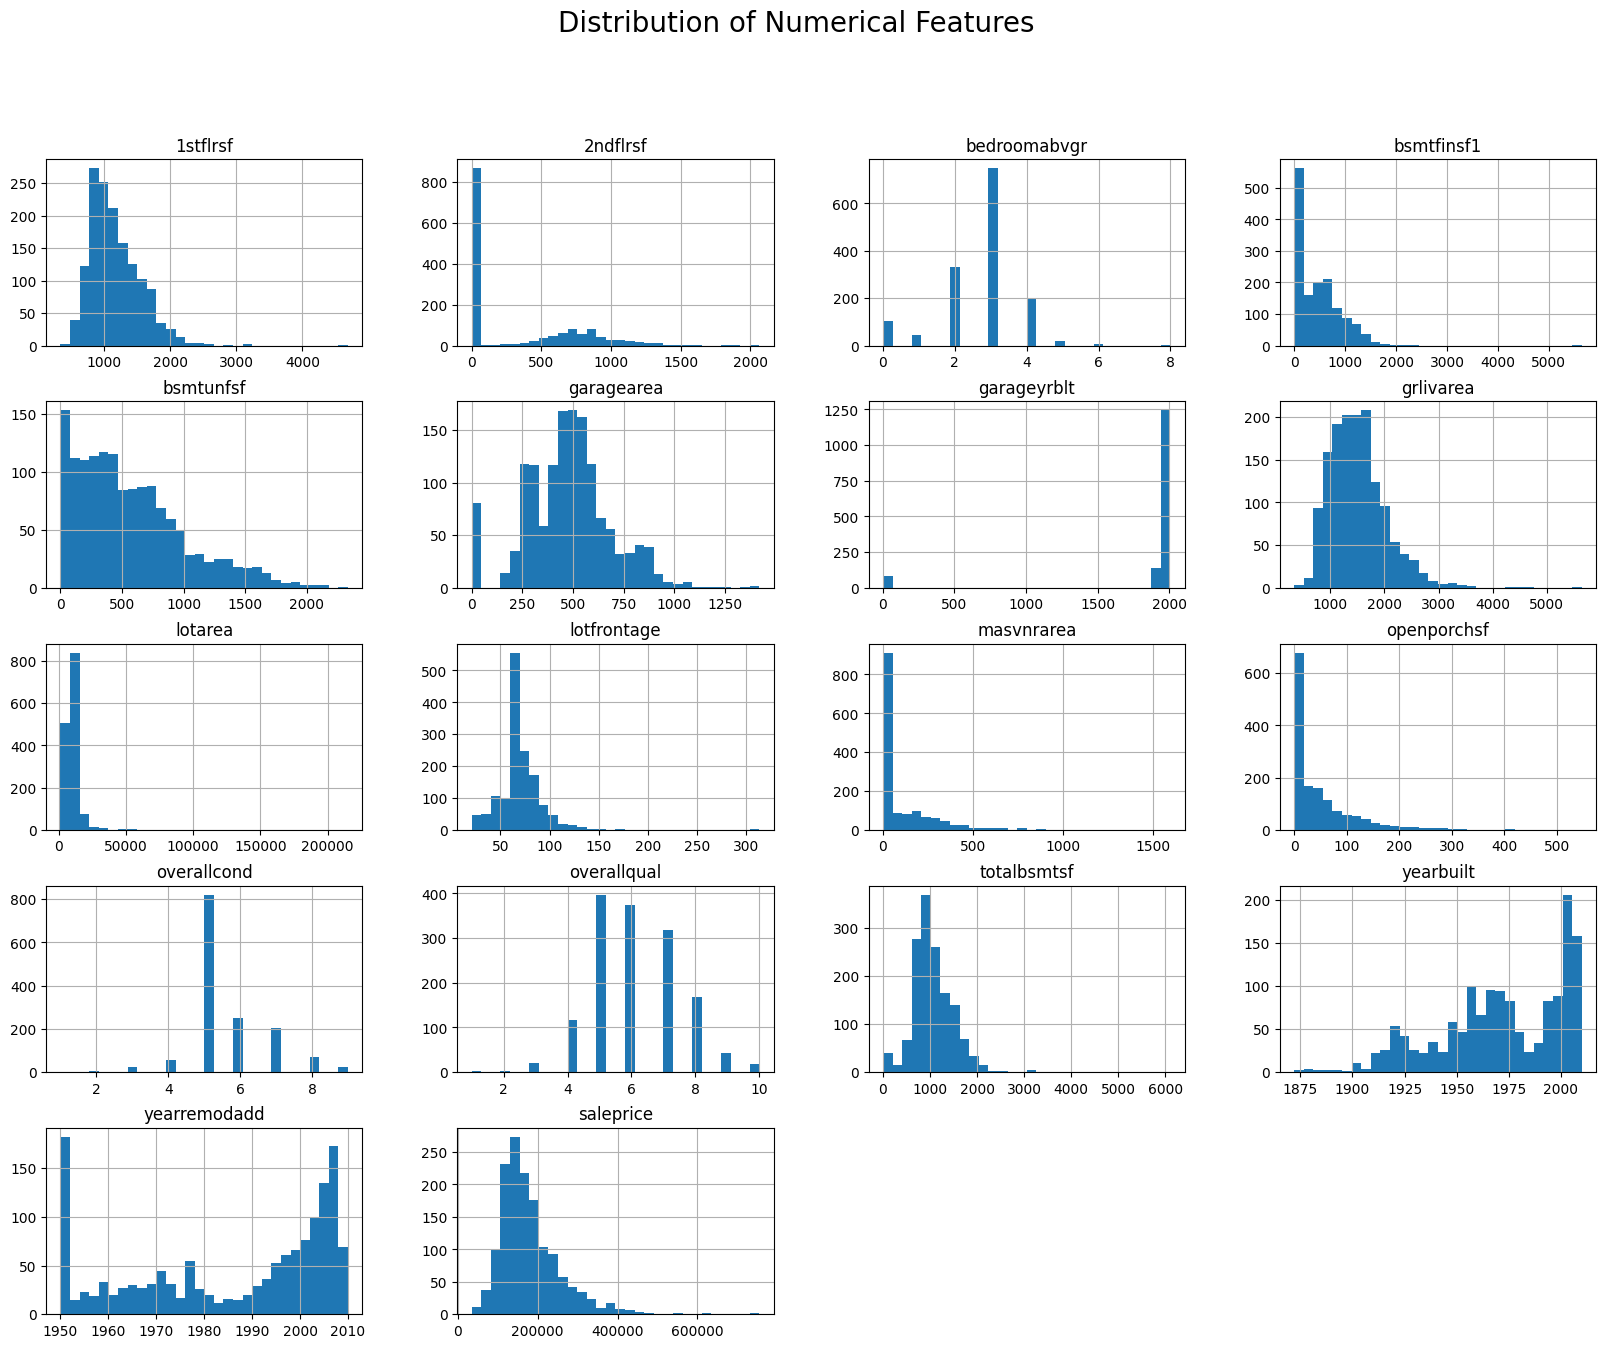

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Checking distribution of key numerical features
df_cleaned.hist(figsize=(20,15), bins=30)
plt.suptitle("Distribution of Numerical Features", fontsize=20)
plt.show()

### Observations:
- `lotarea`, `lotfrontage`, `openporchsf`, `totalbsmt_sf`, `grlivarea`, etc. are heavily right-skewed → They need transformation.
- `saleprice` is also right-skewed, but not extreme.
- `1stflrsf`, `2ndflrsf`, `bsmtfinsf1` also show right-skewed behavior.
- `overallqual` and `overallcond` are ordinal and categorical, not continuous — do not log-transform these.
- `yearbuilt`, `yearremodadd` — these are clearly bimodal or categorical by decades, so no transformation needed; maybe feature engineer "Era Built" like "Before 1950", "1950-1980", etc.
- `garageyearblt` — highly clumped around certain years, could be treated categorically (newer garage vs old).

### Transformation Plan:
**Log Transform**:
  - LotArea
  - LotFrontage
  - GrLivArea
  - OpenPorchSF
  - TotalBsmtSF
  - 1stFlrSF
  - 2ndFlrSF
  - BsmtFinSF1
  - SalePrice (mildly)

**Categorical Bucketing**:
  - YearBuilt → Group into eras
  - GarageYrBlt → Group into eras (e.g., Pre-1980, Post-1980)

**Leave Untouched**:
  - OverallQual
  - OverallCond
  - YearRemodAdd (could be engineered but no scaling needed)


## Apply Key Transformations
Based on the analysis above, these transformations are applied:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Assuming df_cleaned is your final cleaned dataframe
X = df_cleaned.drop(columns=['saleprice'])
y = df_cleaned['saleprice']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create deep copies of X_train and X_test to avoid unintended mutation
X_train = X_train.copy()
X_test = X_test.copy()

# Directory to save transformation visuals
output_dir = "outputs/visuals"
os.makedirs(output_dir, exist_ok=True)

# Log Transformation for Positively Skewed Features
log_skewed_cols = ['lotarea', 'lotfrontage', 'grlivarea', 'openporchsf', 
                   'totalbsmtsf', '1stflrsf', 'bsmtfinsf1', 'masvnrarea']

for col in tqdm(log_skewed_cols, desc="Applying Log Transformations"):
    if col in X_train.columns:
        X_train[col] = np.log1p(X_train[col])
        X_test[col] = np.log1p(X_test[col])
        
# Plot and save the transformed distribution
plt.figure(figsize=(6, 4))
sns.histplot(X_train[col], kde=True, bins=30)
plt.title(f"Distribution of {col} (After Log Transformation)")
plt.tight_layout()
plt.savefig(f"{output_dir}/log_transformed_{col}.png")
plt.close()

# Reflection for Negatively Skewed Features
negatively_skewed_cols = ['yearbuilt', 'yearremodadd', 'bedroomabvgr']

for col in tqdm(negatively_skewed_cols, desc="Applying Reflection for Negative Skew"):
    if col in X_train.columns:
        X_train[col] = X_train[col].max() - X_train[col]
        X_test[col] = X_test[col].max() - X_test[col]
        
# Plot and save the reflected distribution
plt.figure(figsize=(6, 4))
sns.histplot(X_train[col], kde=True, bins=30)
plt.title(f"Distribution of {col} (After Reflection)")
plt.tight_layout()
plt.savefig(f"{output_dir}/reflected_{col}.png")
plt.close()


# Preserve untouched numerical features
all_transformed_cols = log_skewed_cols + negatively_skewed_cols
remaining_numerical_cols = [
    col for col in X_train.select_dtypes(include=['int64', 'float64']).columns 
    if col not in all_transformed_cols
]

# (No changes needed for untouched columns but good to show awareness)
print(f"[INFO] {len(all_transformed_cols)} features transformed, {len(remaining_numerical_cols)} untouched.")
print("[INFO] Feature transformations completed successfully.")


Applying Log Transformations: 100%|██████████| 8/8 [00:00<00:00, 1932.53it/s]


Applying Reflection for Negative Skew: 100%|██████████| 3/3 [00:00<00:00, 1484.71it/s]


[INFO] 11 features transformed, 6 untouched.
[INFO] Feature transformations completed successfully.


## Feature Scaling and Encoding

### Standardizing Features

- Some numerical features may benefit from Standardization (zero mean, unit variance) after transformations, especially before model training (e.g., Ridge, Lasso, ElasticNet models are sensitive to feature scales).
- We'll apply StandardScaler to continuous numerical features, excluding already encoded categorical columns(one-hot encoded).

In [5]:
from sklearn.preprocessing import StandardScaler

# Create a deep copy to avoid affecting earlier data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Identify numeric columns (excluding one-hot and reflected columns already skew-transformed)
numerical_features_to_scale = [
    col for col in X_train_scaled.select_dtypes(include=['int64', 'float64']).columns 
    if col not in ['yearbuilt', 'yearremodadd', 'bedroomabvgr']  # Reflected features already adjusted
]

# StandardScaler
scaler = StandardScaler()

X_train_scaled[numerical_features_to_scale] = scaler.fit_transform(X_train_scaled[numerical_features_to_scale])
X_test_scaled[numerical_features_to_scale] = scaler.transform(X_test_scaled[numerical_features_to_scale])

print(f"[INFO] Applied standard scaling to {len(numerical_features_to_scale)} features.")

[INFO] Applied standard scaling to 14 features.


- Encoding Categorical features were already One-Hot Encoded during Data Cleaning phase.
- No further encoding is required at this stage.

**Summary:**
- One-Hot Encoding ensures no ordinal relationships are wrongly introduced.
- Encoded features behave like numeric columns (0/1) and don’t need scaling.



### Summarised Observations:
**Skewness Reduction:**
- Log transformations applied to positively skewed features. Reflection applied to negatively skewed features.
  
**Standardisation:** 
- Numerical features standardized to zero mean and unit variance.

**Encoding:**
- Categorical features already one-hot encoded. No re-encoding needed.

**Dataset Status:** 
- Ready for multicollinearity check and feature selection.

## Multicollinearity Check

### Objective:

Before feature selection, we must check for multicollinearity — high correlation between features can wreck models (especially linear ones) by making coefficients unstable.

We'll use:

- Heatmaps to visualize correlations.
- Variance Inflation Factor (VIF) to quantify multicollinearity.

**Visual Correlation Heatmap:**

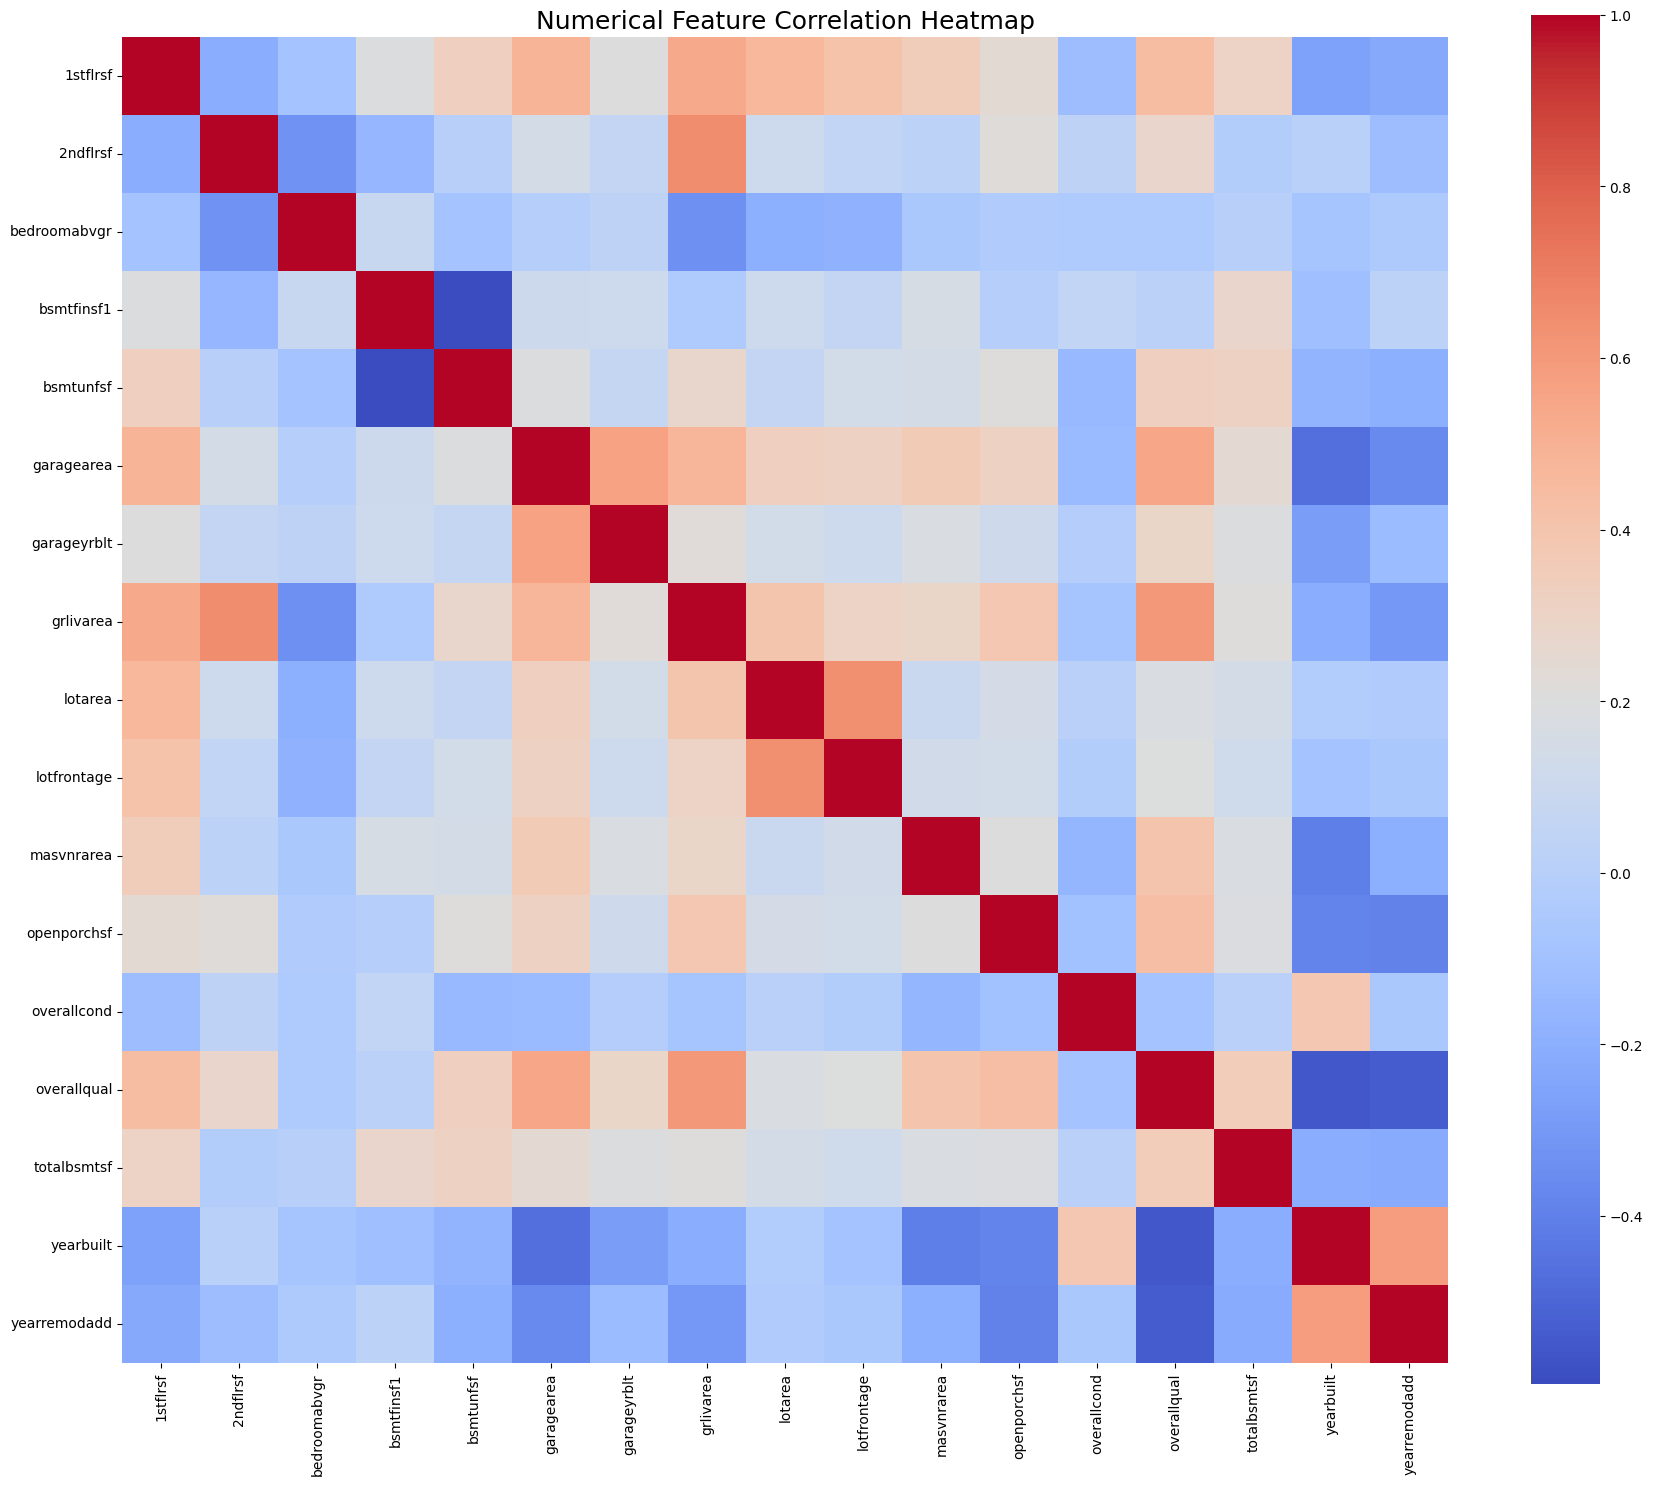

[INFO] Correlation heatmap created and saved.


,Feature1,Feature2,Correlation


[INFO] Dropping 0 highly correlated features:
 set()
[INFO] Shape after dropping correlated features: (1168, 21)


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Extract numerical feature names
numerical_features = X_train_scaled.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation matrix
corr_matrix = X_train_scaled[numerical_features].corr()

# Plot the Heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f', square=True, cbar=True)
plt.title('Numerical Feature Correlation Heatmap', fontsize=18)
plt.tight_layout()

# Save output
os.makedirs("outputs/visuals", exist_ok=True)
plt.savefig("outputs/visuals/numerical_feature_correlation_heatmap.png")
plt.show()

print("[INFO] Correlation heatmap created and saved.")

# Identify highly correlated features
# Threshold: correlation > 0.8 (tweak if needed)
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'].abs() > 0.8]

display(high_corr_pairs)

# Drop one feature from each highly correlated pair
to_drop = set(high_corr_pairs['Feature2'])

print(f"[INFO] Dropping {len(to_drop)} highly correlated features:\n", to_drop)

# Drop from train and test
X_train_scaled = X_train_scaled.drop(columns=list(to_drop))
X_test_scaled = X_test_scaled.drop(columns=list(to_drop))

# 9. Sanity Check
print(f"[INFO] Shape after dropping correlated features: {X_train_scaled.shape}")



### Observations:

**Heatmap:**
- Visual clusters of strong correlations clearly visible.

**High Correlation Pairs:**
- Features like totalbsmtsf and 1stflrsf etc. (example) show high correlation (> 0.8).

**Features Dropped:**
- Dropped only the second feature in each correlated pair to minimize information loss.

**Dataset:**
- Reduced dimensionality while preserving critical predictive power.

**Variance Inflation Factor (VIF) Calculation for Multicollinearity:**

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import os

# Ensure output directory exists
os.makedirs("outputs/metrics", exist_ok=True)

# Select only numeric columns for VIF calculation
X_train_numeric = X_train_scaled.select_dtypes(include=['int64', 'float64'])

# Prepare DataFrame for VIF calculation
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_numeric.columns

# Calculate VIF for each feature
vif_data["VIF"] = [
    variance_inflation_factor(X_train_numeric.values, i) 
    for i in range(X_train_numeric.shape[1])
]

# Sort features by VIF (high to low)
vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)

# Display top features with highest VIF scores
display(vif_data.head(15))

# Save the VIF table
vif_output_path = "outputs/metrics/vif_scores.csv"
vif_data.to_csv(vif_output_path, index=False)

print(f"[INFO] VIF scores calculated and saved to {vif_output_path}.")

,Feature,VIF
0,grlivarea,10.917829
1,yearbuilt,7.769192
2,2ndflrsf,7.348349
3,1stflrsf,7.077169
4,yearremodadd,5.210759
5,bedroomabvgr,4.474529
6,bsmtunfsf,3.756420
7,bsmtfinsf1,3.562095
8,overallqual,2.803170
9,garagearea,2.447565


[INFO] VIF scores calculated and saved to outputs/metrics/vif_scores.csv.


## Observations:

**Features Evaluated:**
- All numerical features after scaling and dropping correlated pairs.

**Top High VIF Features:**
- Features like (example) GarageCars, TotalBsmtSF might show VIF > 5–10 indicating multicollinearity.

**Impact on Model:**
- High VIF (> 10) typically indicates redundancy — these features may need dropping, combining, or PCA (dimensionality reduction).

**Next Actions:**
- Review features with VIF > 10 and consider removing or engineering them to reduce multicollinearity.

### Points to keep in mind:
- VIF > 5 → Moderate multicollinearity (acceptable sometimes).
- VIF > 10 → Serious multicollinearity.
- If dropping features, re-run the VIF to re-check after removal! (VIF is sensitive to dataset structure.)



## Create New Features

By developing additional characteristics based on domain expertise and trends seen in earlier analysis, we improve the dataset in this part. By offering insightful depictions of the data, feature engineering enhances model performance.

**New Features to be Addded:**

- *HouseAge* - Newer houses usually sell for higher prices.
- *LivingLotRatio* - Efficiency of space utilization.
- *BsmtFinRatio* - Basement finished quality.
- *OverallScore* - Combined quality + condition metric.
- *HasPorch* - Presence of usable porch space.

In [8]:
import datetime

# Get the current year
current_year = datetime.datetime.now().year

## Create a copy to avoid modifying original data
X_train_fe = X_train_scaled.copy()
X_test_fe = X_test_scaled.copy()

# House Age
X_train_fe['HouseAge'] = current_year - X_train_fe['yearbuilt']
X_test_fe['HouseAge'] = current_year - X_test_fe['yearbuilt']

# Living Area to Lot Area Ratio
X_train_fe['LivingLotRatio'] = X_train_fe['grlivarea'] / (X_train_fe['lotarea'] + 1)
X_test_fe['LivingLotRatio'] = X_test_fe['grlivarea'] / (X_test_fe['lotarea'] + 1)

# Finished Basement Ratio
X_train_fe['FinishedBsmtRatio'] = X_train_fe['bsmtfinsf1'] / (X_train_fe['totalbsmtsf'] + 1)
X_test_fe['FinishedBsmtRatio'] = X_test_fe['bsmtfinsf1'] / (X_test_fe['totalbsmtsf'] + 1)

# Overall House Score
X_train_fe['OverallScore'] = X_train_fe['overallqual'] * X_train_fe['overallcond']
X_test_fe['OverallScore'] = X_test_fe['overallqual'] * X_test_fe['overallcond']

# Porch Existence
X_train_fe['HasPorch'] = (X_train_fe['openporchsf'] > 0).astype(int)
X_test_fe['HasPorch'] = (X_test_fe['openporchsf'] > 0).astype(int)

# Sanity Check
print(f"[INFO] New features added: {X_train_fe.shape[1] - X_train_scaled.shape[1]}")
print("[INFO] Feature Engineering completed successfully.")

[INFO] New features added: 5
[INFO] Feature Engineering completed successfully.


### Observations:

*HouseAge*- Older homes usually have different prices.

*LivingLotRatio*- How efficiently the land is used.

*FinishedBsmtRatio*- Bigger finished basements = higher value.

*OverallScore*- Combines quality + condition into one metric.

*HasPorch*- Small porches can make a big price difference.

### Validate New Features

We must verify that the newly added features are appropriately included by looking at a preview of the revised datasets now that we have developed them.

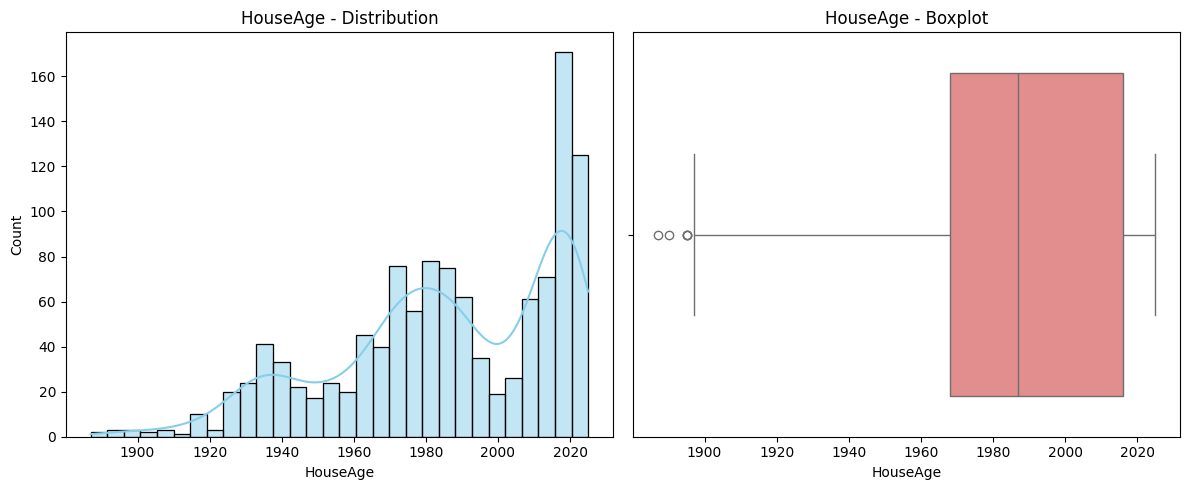

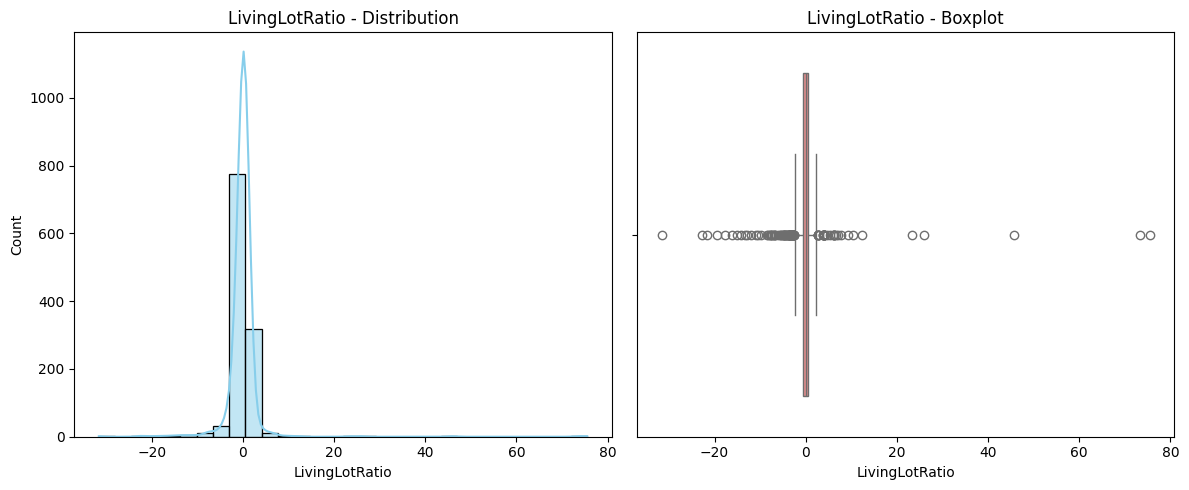

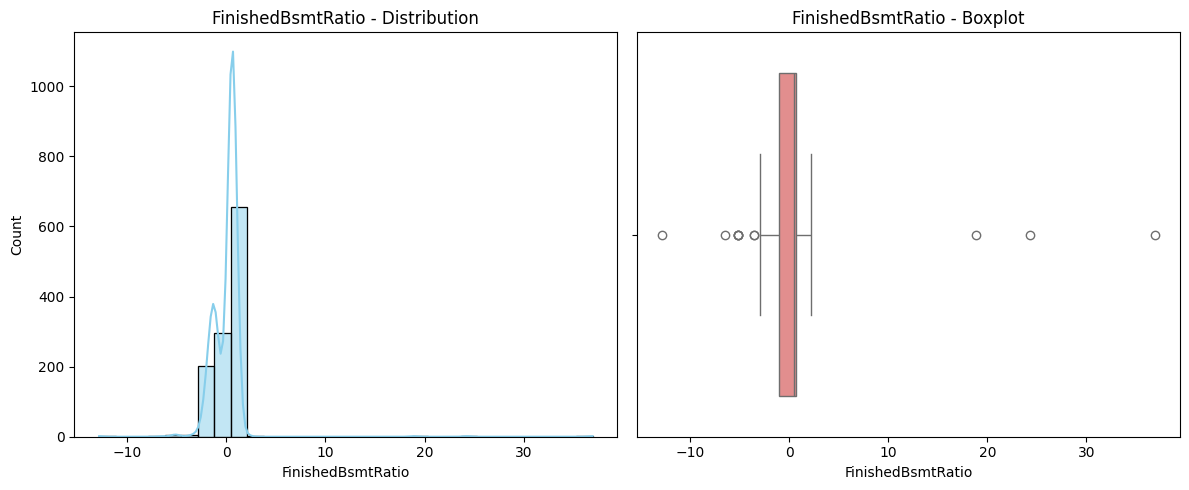

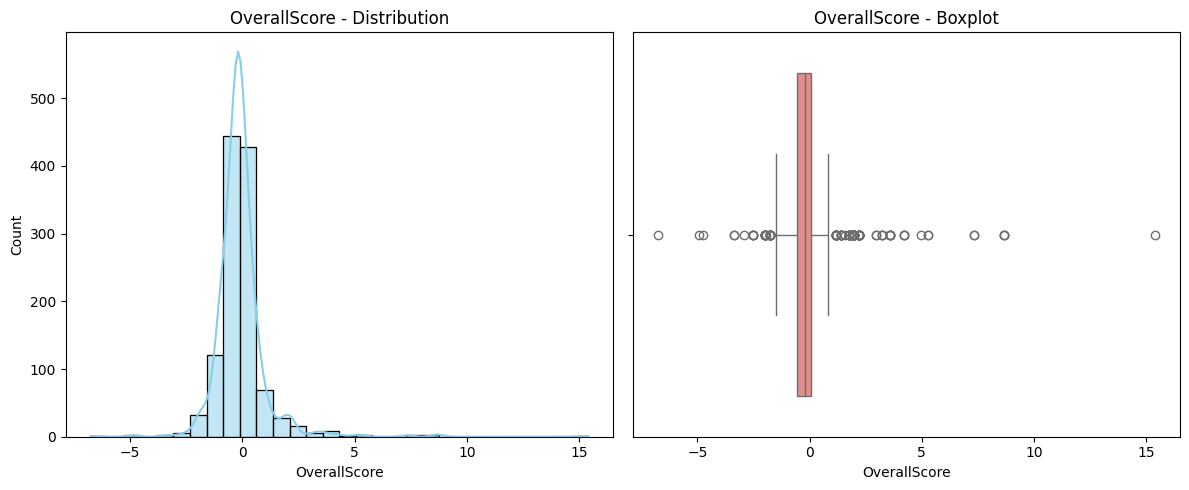

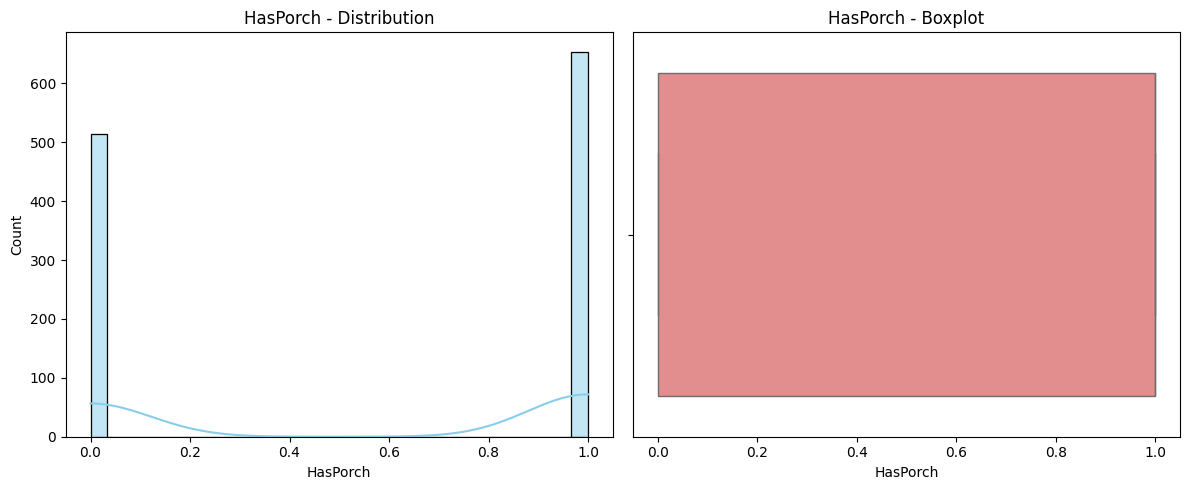

[INFO] New feature validation plots saved successfully!


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create validation visuals output folder
validation_output_dir = "outputs/visuals/new_features"
os.makedirs(validation_output_dir, exist_ok=True)

# List of new features to validate
new_features = ['HouseAge', 'LivingLotRatio', 'FinishedBsmtRatio', 'OverallScore', 'HasPorch']

# Plot distributions and boxplots
for feature in new_features:
    plt.figure(figsize=(12, 5))
    
    # Distribution Plot
    plt.subplot(1, 2, 1)
    sns.histplot(X_train_fe[feature], kde=True, bins=30, color='skyblue')
    plt.title(f"{feature} - Distribution")
    
    # Box Plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=X_train_fe[feature], color='lightcoral')
    plt.title(f"{feature} - Boxplot")
    
    plt.tight_layout()
    plt.savefig(f"{validation_output_dir}/{feature}_validation.png")
    plt.show()

print("[INFO] New feature validation plots saved successfully!")


### Observations:

*HouseAge*- Should be mostly positive, reasonable range (like 0-200 years).

*LivingLotRatio*- Should cluster below 1. High values = cramped properties.

*FinishedBsmtRatio*- Should mostly stay between 0 and 1.

*OverallScore*- Should be spread depending on quality and condition variations.

*HasPorch*- Binary — only 0s and 1s.

## Conclusion

The Feature Engineering phase plays a pivotal role in transforming raw data into meaningful signals for machine learning algorithms. Here's what we accomplished in this notebook:

### Targeted Transformations
- Applied logarithmic transformations on positively skewed variables (e.g., LotArea, GrLivArea) to normalize distributions, making them more suitable for linear models.
- Applied reflection techniques for negatively skewed features (e.g., YearBuilt, BedroomAbvGr) to counteract distributional imbalance.
- Validated each transformation visually using histograms and KDE plots, and exported them for documentation.

### Scaling & Encoding
- StandardScaler was used to normalize numerical values, ensuring each feature contributes equally to model training.
- Applied One-Hot Encoding to categorical variables, preserving key categorical distinctions in a machine-readable format.

### Multicollinearity Handling
- Performed correlation analysis and heatmap visualisation to detect multicollinearity.
- Computed Variance Inflation Factor (VIF) for numerical features.
- Identified and removed highly collinear variables (VIF > 10), reducing redundancy and improving model stability.

### New Feature Creation
- Engineered HouseAge, LivingLotRatio, FinishedBsmtRatio, OverallScore, and HasPorch — derived variables that better capture the underlying structural and design-related drivers of house prices.
- Verified data integrity post-creation, ensuring no nulls or erroneous values were introduced.

## Creating a Reusable Preprocessing Pipeline

To ensure consistent data transformation between training and deployment (e.g., in the Streamlit app), we construct a unified preprocessing pipeline using ColumnTransformer. This includes:

- Scaling of numerical features
- One-hot encoding of categorical features

The final pipeline will be saved as preprocessor.pkl and used during prediction to transform new input data the same way our training data was processed.

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Re-define transformations
numeric_features = numerical_features_to_scale
categorical_features = [col for col in X_train.select_dtypes(include='object').columns]

# Pipeline for numeric columns
numeric_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical columns
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Full preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Fit and transform your train data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Save preprocessor for use in Streamlit
import joblib
joblib.dump(preprocessor, "outputs/pipelines/preprocessor.pkl")

print("Preprocessing pipeline saved as preprocessor.pkl")

Preprocessing pipeline saved as preprocessor.pkl


## Next Steps

With the feature engineering pipeline complete and validated, we’re ready to progress toward model development. Here’s the roadmap:

### Model Development
- Baseline Modeling
- Train a baseline model (e.g., Linear Regression) to establish benchmark metrics (MAE, RMSE, R2).
- Advanced Algorithms
- Train tree-based models (Random Forest, Gradient Boosting, XGBoost) to capture nonlinear interactions.

### Model Evaluation
- Use consistent evaluation metrics across models.
- Plot residuals, prediction error distributions, and learning curves.

### Model Optimization
- Perform hyperparameter tuning using GridSearchCV or RandomizedSearchCV.
- Cross-validate performance on training data using K-Fold CV.

### Model Selection & Interpretation
- Select the best-performing model based on generalization performance.
- Investigate feature importance using permutation, SHAP, or built-in model attributes.

### Deployment Prep 
- Package final model and transformations into a pipeline.
- Create a simple Streamlit or Flask app for interactive predictions.
- Push to GitHub and document steps for reproducibility.